In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torchtext.vocab import build_vocab_from_iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%run models/RNN.ipynb

In [2]:
train_iter = SST2(split="train")
val_iter = SST2(split="dev")

tokenizer = get_tokenizer('spacy')


def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocabulary = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

D:\Python\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [3]:
def yield_tokens_adv(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocabulary = build_vocab_from_iterator(yield_tokens_adv(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [4]:
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())

In [5]:
BATCH_SIZE = 128


def collate(x):
    batch = []
    for item in x:
        seq = []
        for word in tokenizer(item[0]):
            seq.append(vocabulary[word])
        batch.append(torch.tensor(seq))
    l = torch.tensor([item[1] for item in x]).unsqueeze(dim=1)
    return nn.utils.rnn.pad_sequence(batch, padding_value=vocabulary["<pad>"], batch_first=True), l

In [6]:
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=lambda x: collate(x), drop_last=True)
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=lambda x: collate(x), drop_last=True)

In [7]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 2

model = RNN(vocabulary, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 40,802 trainable parameters



## Train the Model

In [9]:
optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss().to(device)
model = model.to(device).float()
criterion = criterion.to(device)

In [10]:
def binary_accuracy(preds, y):
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [11]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    c = 0
    for inputs, labels in iterator:
        c += 1
        inputs = inputs.to(device)
        labels = labels.view(-1).to(device)
        optimizer.zero_grad()
        predictions, _ = model(inputs)
        predictions = predictions.float()
        loss = criterion(predictions, F.one_hot(labels, num_classes=2).float())
        acc = binary_accuracy(predictions.argmax(-1), labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / c, epoch_acc / c

In [12]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    c = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in iterator:
            c += 1
            inputs = inputs.to(device)
            labels = labels.view(-1).to(device)
            predictions, _ = model(inputs)
            predictions = predictions.float()
            loss = criterion(predictions, F.one_hot(labels, num_classes=2).float())
            acc = binary_accuracy(predictions.argmax(-1), labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / c, epoch_acc / c

In [13]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:


N_EPOCHS = 20

best_valid_loss = float('inf')

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss > best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/rnn.pt')

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.483 | Train Acc: 76.72%
	 Val. Loss: 0.514 |  Val. Acc: 75.52%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.435 | Train Acc: 80.05%
	 Val. Loss: 0.539 |  Val. Acc: 76.04%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.415 | Train Acc: 81.03%
	 Val. Loss: 0.539 |  Val. Acc: 74.22%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.404 | Train Acc: 81.91%
	 Val. Loss: 0.526 |  Val. Acc: 76.17%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.497 | Train Acc: 73.38%
	 Val. Loss: 0.565 |  Val. Acc: 76.04%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.487 | Train Acc: 76.34%
	 Val. Loss: 0.610 |  Val. Acc: 68.88%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.455 | Train Acc: 79.03%
	 Val. Loss: 0.556 |  Val. Acc: 73.57%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.438 | Train Acc: 80.39%
	 Val. Loss: 1.210 |  Val. Acc: 59.77%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.624 | Train Acc: 63.03%
	 Val. Loss: 0.674 |  Val. Acc: 60.16%
Epoch: 10 | Epoch Time: 0m 7

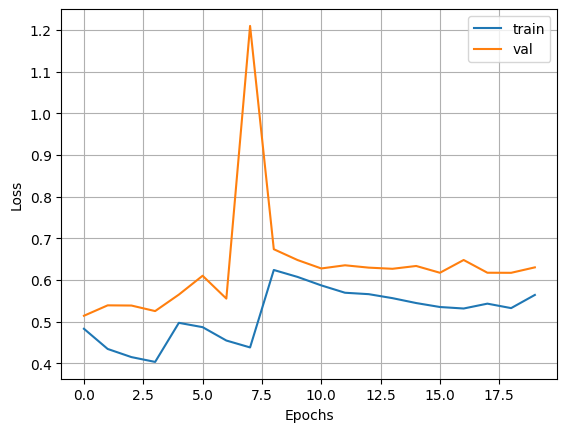

In [15]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

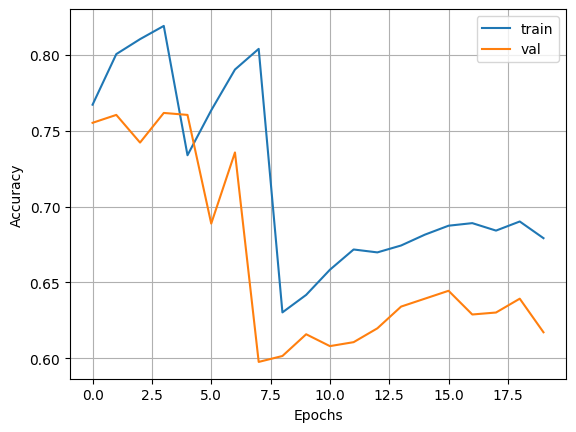

In [16]:
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()